Example of using `interarray` for routing the cables of a wind farm location with 122 turbines and 2 substations, which has a concave cable-laying area and one obstacle within that area.

Additional complexity on the geometry of the location has negligible impact on the solving time, as it does not increase the number of variables in the MILP model.

In [1]:
from matplotlib import pyplot as plt
import pyomo.environ as pyo

In [2]:
from interarray.importer import load_repository
from interarray.plotting import gplot
from interarray.svg import svgplot
from interarray.interarraylib import calcload, G_from_S
from interarray.mesh import make_planar_embedding
from interarray.pathfinding import PathFinder
from interarray.EW_presolver import EW_presolver
import interarray.MILP.pyomo as omo

In [3]:
%config InlineBackend.figure_formats = ['svg']

## Solvers

Using a MILP solver can produce better solutions. This notebook uses Gurobi but examples for other solvers can be found in the *MILP* notebooks.

There are some differences in solver parameters even for the ones supported through pyomo.

Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are free software.

In [4]:
gurober = pyo.SolverFactory('gurobi', solver_io='python')
gurober.available(), type(gurober)

(True, pyomo.solvers.plugins.solvers.gurobi_direct.GurobiDirect)

## Load input data

In [5]:
locations = load_repository()

Using example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593>.

In [6]:
L = locations.taylor_2023

Note: To view SVG cell outputs, trust this notebook first.

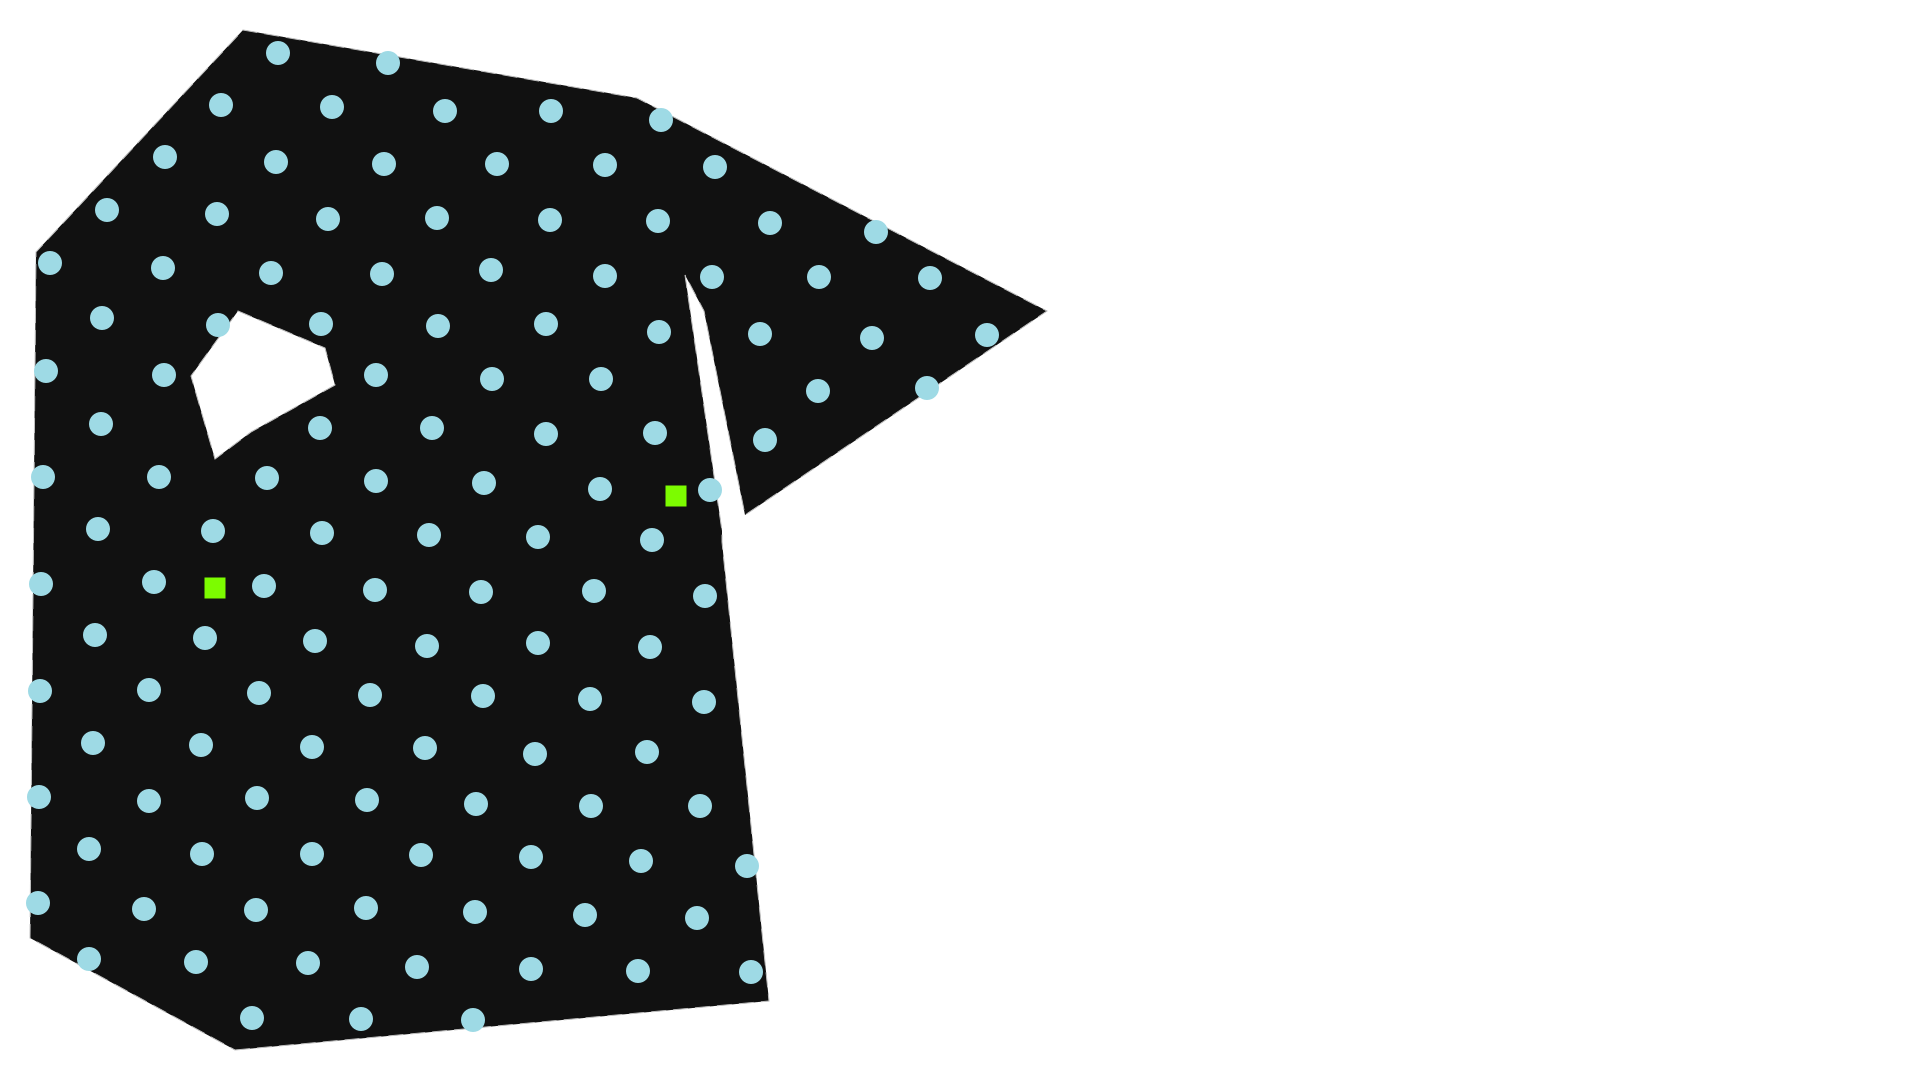

In [7]:
svgplot(L, landscape=False)

When the location has more than one substation, we cannot use the *HGS-CVRP* meta-heuristic. Instead, we may use a very fast heuristic: *Esau-Williams presolver* (**EW_presolver**).

**EW_presolver** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

## Generate the warm-start solution

In [8]:
P, A = make_planar_embedding(L)

In [9]:
S_pre = EW_presolver(A, capacity=8)

## Visualizing the warm-start solution

This section is unecessary in production.

In [10]:
G_pre = G_from_S(S_pre, A)

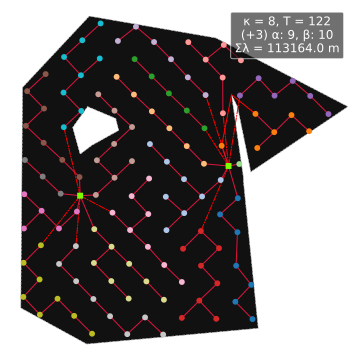

In [11]:
gplot(G_pre, landscape=False);

If we wanted to use that solution, we should add detours to the feeder cables that have forbidden crossings:

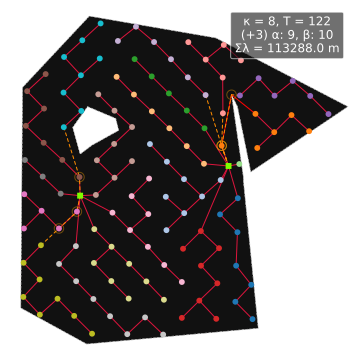

In [12]:
H_pre = PathFinder(G_pre, planar=P, A=A).create_detours()
gplot(H_pre, landscape=False);

## Create MILP model and optimize it

In [13]:
model = omo.make_min_length_model(
    A, S_pre.graph['capacity'],
    gateXings_constraint=False,
    gates_limit=False,
    branching=True
)
omo.warmup_model(model, S_pre);

In [14]:
gurober.options.mipgap = 0.005  # 0.5 %
gurober.options.timelimit = 90  # [s]
gurober.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
result = gurober.solve(model, warmstart=model.warmed_by, tee=True)

Solving "taylor_2023": {R=2, T=122, k=8}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 90
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  90
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4444 rows, 2896 columns and 16572 nonzeros
Model fingerprint: 0xa0f96ff1
Variable types: 0 continuous, 2896 integer (1448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 113164

Presolve removed 653 rows and 0 columns
Presolve t

## Trace routes from solution topology

In [15]:
S = omo.S_from_solution(model, gurober, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()

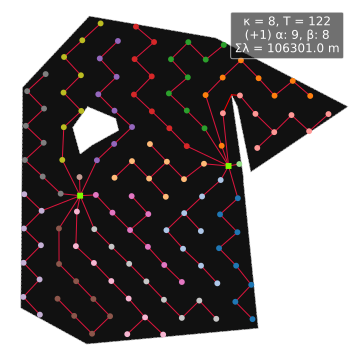

In [16]:
gplot(H, landscape=False);